In [2]:
# importing libraries
import re
import os
import json
import warnings
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Set your API key
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# loading & exploring data
books = pd.read_csv('books.csv')
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [4]:
# shape
books.shape

(6810, 12)

In [5]:
# dataset information
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [6]:
# null data
null_percentage = books.isnull().sum().reset_index().rename(columns={"index":"Feature", 0:"Null %"})
null_percentage['Null %'] = round((null_percentage['Null %']/books.shape[0])*100).astype('int')
null_percentage

,Feature,Null %
0,isbn13,0
1,isbn10,0
2,title,0
3,subtitle,65
4,authors,1
5,categories,1
6,thumbnail,5
7,description,4
8,published_year,0
9,average_rating,1


In [7]:
# duplicate data
books.duplicated().sum()

np.int64(0)

In [8]:
# number of unique features
books[['title','subtitle', 'categories','thumbnail','description']].nunique()

,0
title,6398
subtitle,2009
categories,567
thumbnail,6481
description,6474


In [9]:
# Missing Data that we can ignore as it is not that much
books_data = books[~(books['description'].isna()) &
      ~(books['num_pages'].isna()) &
      ~(books['average_rating'].isna()) &
      ~(books['published_year'].isna())
]

books_data.shape

(6507, 12)

In [10]:
# Date is not balanced at all as the values varies too much
books_data['categories'].value_counts().reset_index().sort_values('count',ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
519,"Adventure stories, English",1
518,Germany,1
517,Egypt,1
516,Apartments,1


In [11]:
# Creating a new feature with description words
books_data['description_words'] = books_data['description'].str.split().str.len()

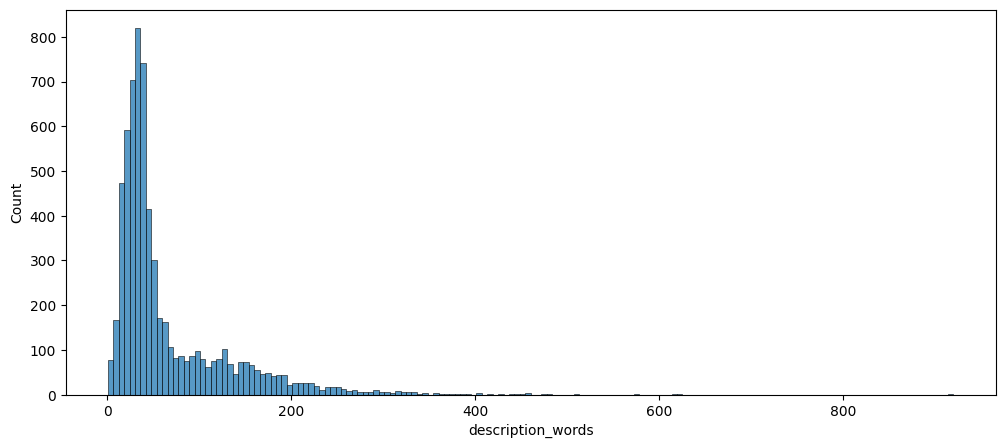

In [12]:
# plotting total words in book description
plt.figure(figsize=(12,5))
sns.histplot(books_data['description_words'])
plt.show()

In [13]:
# According to my assumption 25 words will be sufficient
books_data_25Words = books_data[books_data['description_words']>25]
books_data_25Words.shape

(5088, 13)

In [14]:
# Creating a new feature where we will merge subtitle in title is there is any else return title
books_data_25Words['title_and_subtitle'] = (
    np.where(books_data_25Words['subtitle'].isna(), books_data_25Words['title'],
            books_data_25Words[['title','subtitle']].astype(str).agg(": ".join, axis=1)
            )
)

In [15]:
# Tagged Description
books_data_25Words['tagged_description'] = (
    books_data_25Words[['isbn13', 'description']].astype(str).agg(' '.join, axis=1)
)

In [16]:
# Dropping useless columns
books_data_25Words.drop(columns=['subtitle','description_words'], axis=1, inplace=True)

In [17]:
# Dropping null data for authors
books_data_25Words.dropna(subset=['authors'], inplace=True)

In [18]:
# Clean Dataset
books = books_data_25Words.copy()

## Category Classification

In [19]:
# Creating New Feature broad_category for books

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Step 1: Extract unique category strings
unique_cats = books['categories'].dropna().unique().tolist()

# Step 2: Batch helper
def batched(iterable, batch_size):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i:i + batch_size]

# Step 3: Classify a batch using Gemini
def classify_batch(cat_list):
    prompt = f"""
                You are an expert in classifying book categories and you are the best one.
                Given each of the following category strings, choose the best matching single category from this list:
                - Fiction
                - Non Fiction
                - Children Fiction
                - Children Non Fiction

                Return ONLY a valid JSON object mapping each input string to one category.
                No explanations. No markdown. No code blocks.

                Here is the list:
                {json.dumps(cat_list, ensure_ascii=False, indent=2)}
            """

    resp = llm.invoke([HumanMessage(content=prompt)])

    # Try to extract JSON from response safely
    raw_output = resp.content.strip()
    match = re.search(r"\{.*\}", raw_output, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError as e:
            print("JSON decode error:", e)
            print("Raw output:", raw_output)
            return {}
    else:
        print("No JSON object found in LLM output:\n", raw_output)
        return {}

# Step 4: Build mapping for all unique categories
mapping = {}
for batch in batched(unique_cats, 50):
    batch_result = classify_batch(batch)
    mapping.update(batch_result)


# Step 5: Apply mapping to your DataFrame
books['broad_category'] = (
    books['categories']
    .map(mapping)              # map known categories
    .fillna('Fiction')         # fallback to 'Fiction' if something is missed
)

In [20]:
# Values Counts for broad_category
books['broad_category'].value_counts()

,count
broad_category,
Fiction,2617
Non Fiction,1961
Children Fiction,412
Children Non Fiction,68


### Sentiment Analysis

In [21]:
import torch

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Load model and tokenizer
model_id = 'j-hartmann/emotion-english-distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# Create pipeline with GPU support
classifier = pipeline("text-classification",
                      model=model,
                      tokenizer=tokenizer,
                      top_k=None,
                      truncation=True,
                      device=device)


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0


In [22]:
# trying on sample data
print(books['description'][1])
classifier(books['description'][1])[0]

A new 'Christie for Christmas' -- a full-length novel adapted from her acclaimed play by Charles Osborne Following BLACK COFFEE and THE UNEXPECTED GUEST comes the final Agatha Christie play novelisation, bringing her superb storytelling to a new legion of fans. Clarissa, the wife of a Foreign Office diplomat, is given to daydreaming. 'Supposing I were to come down one morning and find a dead body in the library, what should I do?' she muses. Clarissa has her chance to find out when she discovers a body in the drawing-room of her house in Kent. Desperate to dispose of the body before her husband comes home with an important foreign politician, Clarissa persuades her three house guests to become accessories and accomplices. It seems that the murdered man was not unknown to certain members of the house party (but which ones?), and the search begins for the murderer and the motive, while at the same time trying to persuade a police inspector that there has been no murder at all... SPIDER'S

[{'label': 'fear', 'score': 0.7555213570594788},
 {'label': 'sadness', 'score': 0.08561994880437851},
 {'label': 'surprise', 'score': 0.0688435286283493},
 {'label': 'neutral', 'score': 0.05059080198407173},
 {'label': 'anger', 'score': 0.018281808122992516},
 {'label': 'disgust', 'score': 0.018019134178757668},
 {'label': 'joy', 'score': 0.0031234645284712315}]

In [23]:
# Creating an empty dataframe
df = pd.DataFrame(columns=['fear', 'neutral', 'sadness', 'surprise', 'disgust', 'joy', 'anger'])

# Function to extract scores as a dictionary
def get_scores_dict(text):
    result = classifier(text)
    if isinstance(result, list) and isinstance(result[0], list):
        result = result[0]
    return {d['label']: d['score'] for d in result}


tqdm.pandas()
scores_series = books['description'].progress_apply(get_scores_dict)
emotion_df = pd.json_normalize(scores_series)
emotion_df['isbn13'] = books['isbn13'].values
emotion_df = emotion_df.set_index('isbn13')
emotion_df.head()

  0%|          | 0/5058 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,fear,neutral,sadness,surprise,disgust,joy,anger
isbn13,,,,,,,
9780002005883,0.654841,0.169852,0.116409,0.020701,0.019101,0.015161,0.003935
9780002261982,0.755521,0.050591,0.085620,0.068844,0.018019,0.003123,0.018282
9780006178736,0.939291,0.007241,0.002299,0.003145,0.005369,0.018979,0.023676
9780006280897,0.230528,0.201328,0.027787,0.004284,0.198185,0.005105,0.332783
9780006280934,0.004750,0.854798,0.015526,0.004517,0.068829,0.029622,0.021958


In [24]:
# Merging & Saving the new csv file
merged_df = pd.merge(books, emotion_df, on='isbn13', how='left')
merged_df.to_csv('books_with_emotion_scores.csv', index=False)